# BERT Analysis

Approaching using BERT to analyze the overview column plan:
* Problem Understanding
  * Extract themes, genres, or patterns that correlate with popularity
  * BERT can reveal the underlying patterns by identifying contextual keywords and themes
* Using BERT for Key Information Extraction
  * BERT is a pre-trained model that reads text in both directions (both directions means that it reads starting from the left and the right side)
  * This is good for understanding word context better
  * Encoder vs. Decoder
    * Encoder: Extracts contextual information (good for classification, clustering)
      * Goal is to assign labels (genre, sentiment) based on the content OR Goal is to group similar texts together based on their meaning or themes
      * BERT understands word meanings more since it reads both left and right contexts
    * Decoder: Generates sequences (like summaries or paraphrasing)
  * Encoder would be best since we can classify the theme of the show as "romance," "heist," etc.
  * Decoder might be used if we need to summarize the overview or generate a more compact feature from it

# Feature Extractions via Embeddings
* Convert each overview into BERT embeddings, which is our vector representations
* Use a pre-trained BERT model form Hugging Face (bert-base-uncased) to generate enbeddings
  * BERT-base is the original configuration of the BERT model
  * Using uncased model since the capitalization does not impact the meaning
  * Will test the results of the BERT model on cleaned and uncleaned text data
    * Read that using over cleaned data into the BERT model can negatively affect its performance
  * Can use cosine similarity to show the similarity between overviews (clustering shows with similar themes)

In [1]:
import pandas as pd
import os
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

TMDB_filename = os.path.join(os.getcwd(), "TMDB_tv_dataset_v3.csv")
df = pd.read_csv(TMDB_filename)

/var/folders/m4/60ljkntj7gs489xq6yv_ghnm0000gn/T/ipykernel_7320/626329652.py:9: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(TMDB_filename)


In [2]:
# import transformers library, which is a popular open-source library from HUgging Face
from transformers import BertTokenizer, BertModel
# import PyTorch to develop and train deep learning models
import torch
from tqdm import tqdm  # for progress bar

# loading the pre-trained BERT model and tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# tokenize and create tensor input
def get_embedding(text): 
  if pd.isnull(text):
    return torch.zeros(model.config.hidden_size).tolist()
  '''
  padding is set to true so that all input sequences have the same length
  truncation is set to true so that it truncates longer sequences that are longer
  than the models maximum input length so the text does not exceed the models capacity
  'return_tensor="pt"' means the output should be returned as a PyTorch tensor since the 
  model requires input in tensor format to perform computations
  '''
  tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)
  '''
  torch.no_grad() disables gradient tracking to reduce memory consumption for computations that do not require gradients
  model(**tokens) passes the tokenized input to the pre-trained model (BERT)
  '''
  with torch.no_grad(): # generate embeddings 
    outputs = model(**tokens)
  '''
  outputs.last_hidden_state retrieves the hidden states from the last layer of the model for all tokens in the input sequence.
  Each token has an associated embedding vector.
  mean(dim=1) calculates the mean of the embeddings along the token dimension, which produces a single embedding vector for the entire input text, which
  can be used for various downstream tasks like classification, clustering, etc.
  '''
  return outputs.last_hidden_state.mean(dim=1).squeeze().tolist() # average pooling of embedings


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/safiaboutaleb/Developer/directv_tvrec/myenv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/safiaboutaleb/Developer/directv_tvrec/myenv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/safiaboutaleb/Developer/directv_tvrec/myenv/lib/python3.11/site-packages/ipyk

In [3]:
# function to process the DataFrame with progress tracking
def process_with_progress(series):
  embeddings = []
  for text in tqdm(series, desc="Processing Embeddings"):
    embeddings.append(get_embedding(text))
  return embeddings

* Use the get_embedding function on the text data from the overview column
### ONLY RUN THIS CODE CELL IF THE CSV FILE DOES NOT YET HAVE THE BERT EMBEDDINGS

In [4]:
# process the overview column and assign embeddings to a new column
df['bert_cleaned_overview'] = process_with_progress(df['overview'])

print("Processing complete!")

Processing Embeddings: 100%|██████████| 168593/168593 [2:11:52<00:00, 21.31it/s]   


Processing complete!


# Clustering/Classification
* After converting the overviews to embeddings:
  * Use clustering algorithms (K-Means) to find shows with similar themes
  * Classification model to predict genre based on overview content
  * If we noticed that certain clustered shows share a theme like "heist" we can make this a new feature in our dataset

In [5]:
# preprocess by ensuring the embeddings are in a suitable format (numpy array) and potentially normalize them
embeddings_array = np.vstack(df['bert_cleaned_overview'].to_numpy())

In [6]:
# use MiniBatchKMeans since it is a memory-efficient and faster version of KMeans that avoids some threading issues so we can do the clustering
from sklearn.cluster import MiniBatchKMeans

# 
num_clusters = 5
kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=100)
df['cluster'] = kmeans.fit_predict(embeddings_array)

/Users/safiaboutaleb/Developer/directv_tvrec/myenv/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


* Since we are using BERT-base embeddings, each embedding vector has 768 dimensions
* This means for every text in our dataset, there is a 768-dimensional vector

In [7]:
# inspect the shape to see the dimension of the data
print(f"Shape of embeddings array: {embeddings_array.shape}")

Shape of embeddings array: (168593, 768)


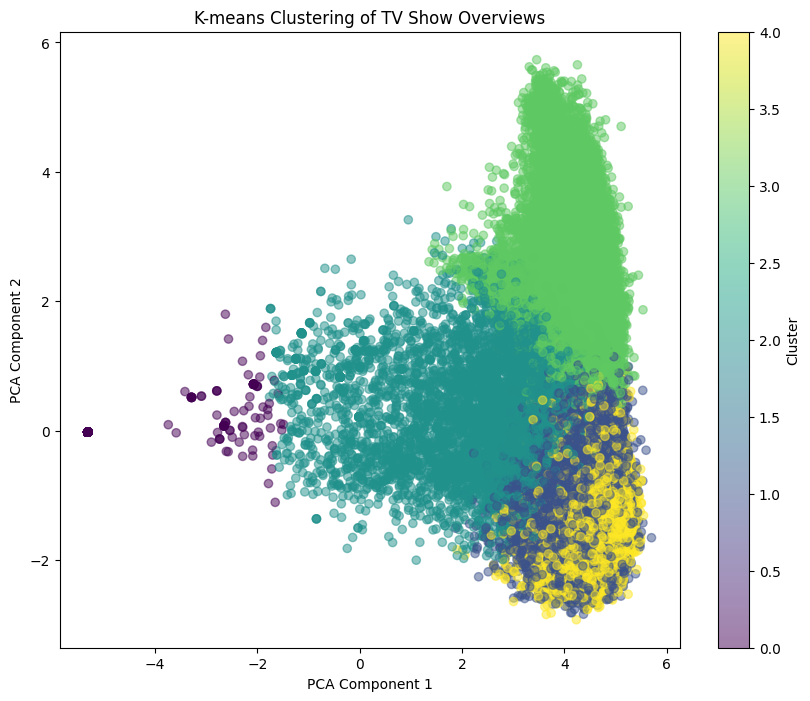

In [8]:
# using PCA to reduce dimensionality since the data is high-dimensional when visualizing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2) # reduce dimensions to 2 for visualization
reduced_embeddings = pca.fit_transform(embeddings_array)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.title('K-means Clustering of TV Show Overviews')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

### K-means clustering results for TV show overviews reduced to two dimensions using PCA
* Axes (PCA Component 1 and 2)
  * The first two principle components resulting from PCA (PCA is used to reduce the dimensionality of the data)
  * Since the BERT embedings were high-dimensional, PCA was applied to project them in a 2D space
* Clusters
  * Each point represent a TV shows overview text that was converted into a BERT embedding
  * We specified 5 clusters, so the data points are grouped based on the similarity
  * The similarity between tv shows is based on the semantic meaning captured by the BERT embeddings
  * Shows that are closer have more similar content in their overviews, while shows in different clusters have distinct textual differences
  * The color bar on the right hand side indicates the cluster label assigned by the K-means algorithm
    * The numbers 0, 1, 2, 3, 4 correspond to different clusters
* Insights
  * The overlap in the clusters means that some TV shows share themes across multiple groups
  * The isolated blue cluster on the right could suggest a group of TV shows with overviews that are semantically distinct from other shows

### Next Steps
* Analyze the content of the clusters by looking at the shows in each group
* Experiment with more clusters

View Sample Data for Each Cluster

In [9]:
for cluster_id in range(num_clusters):
  print(f"\nCluster {cluster_id}:")
  display(df[df['cluster'] == cluster_id][['name', 'overview', 'genres']].head(10))


Cluster 0:


,name,overview,genres
245,40 y 20,Unknown,['Comedy']
391,Ecomoda,Unknown,"['Comedy', 'Drama']"
441,Rosario Tijeras,Unknown,"['Action & Adventure', 'Crime', 'Drama']"
489,Rubi,Unknown,['Soap']
524,A Family of Ten,Unknown,['Comedy']
657,El Chapulín Colorado,Unknown,"['Comedy', 'Family', 'Crime', 'Sci-Fi & Fantas..."
719,María de Todos los Ángeles,Unknown,"['Drama', 'Comedy', 'Family']"
832,Amar a Muerte,Unknown,"['Drama', 'Soap']"
901,La Familia del Barrio,Unknown,['Comedy']
943,A Terra Prometida,Unknown,['Soap']



Cluster 1:


,name,overview,genres
0,Game of Thrones,Seven noble families fight for control of the ...,"['Sci-Fi & Fantasy', 'Drama', 'Action & Advent..."
1,Money Heist,"To carry out the biggest heist in history, a m...","['Crime', 'Drama']"
2,Stranger Things,"When a young boy vanishes, a small town uncove...","['Drama', 'Sci-Fi & Fantasy', 'Mystery']"
3,The Walking Dead,Sheriff's deputy Rick Grimes awakens from a co...,"['Action & Adventure', 'Drama', 'Sci-Fi & Fant..."
4,Lucifer,"Bored and unhappy as the Lord of Hell, Lucifer...","['Crime', 'Sci-Fi & Fantasy']"
5,Riverdale,"Set in the present, the series offers a bold, ...","['Crime', 'Drama', 'Mystery']"
6,Squid Game,Hundreds of cash-strapped players accept a str...,"['Action & Adventure', 'Mystery', 'Drama']"
7,Breaking Bad,"When Walter White, a New Mexico chemistry teac...","['Drama', 'Crime']"
8,The Good Doctor,"Shaun Murphy, a young surgeon with autism and ...",['Drama']
9,WandaVision,Wanda Maximoff and Vision—two super-powered be...,"['Sci-Fi & Fantasy', 'Mystery', 'Drama']"



Cluster 2:


,name,overview,genres
544,American Horror Stories,An anthology series of stand alone episodes de...,"['Drama', 'Mystery', 'Sci-Fi & Fantasy']"
735,Last Week Tonight with John Oliver,A half-hour satirical look at the week in news...,"['Talk', 'Comedy', 'News']"
875,SIX,Action drama series inspired by the real missi...,"['War & Politics', 'Drama', 'Crime', 'Action &..."
1034,BTS In the SOOP,"'In the SOOP BTS ver.' is a reality show, port...",['Reality']
1110,Súbete a mi moto,The Story behind the the iconic boy band Menud...,['Drama']
1151,Magnificent Century: Kösem,Tells the legendary story between the Sultan o...,['Drama']
1195,Run BTS!,"Run BTS! is a variety web series starring BTS,...",['Reality']
1222,MATARIFE,"Matarife, an unmentionable genocide | The seri...",['Documentary']
1229,Line of Duty,"A drama about the investigations of AC-12, a c...","['Crime', 'Drama', 'Mystery']"
1332,31 Minutos,Chilean television show which takes the form o...,"['Comedy', 'Kids', 'Family']"



Cluster 3:


,name,overview,genres
93,"Yo soy Betty, la fea","Yo soy Betty, la fea is a telenovela filmed in...","['Soap', 'Comedy', 'Drama']"
321,What Life Took From Me,"""What Life Took From Me"" is a Mexican telenove...",['Drama']
368,Without Breasts There Is No Paradise,Sin Senos no hay Paraíso is a RTI Colombia–Tel...,"['Action & Adventure', 'Drama']"
388,The Tom and Jerry Show,The New Tom & Jerry Show is an animated televi...,"['Animation', 'Comedy', 'Kids', 'Family']"
407,Zoey 101,Zoey 101 is an American television series whic...,"['Drama', 'Comedy']"
473,Atrévete a soñar,"Danna Paola stars as Patito, Eleazar Gómez as ...",['Drama']
500,Little House on the Prairie,Little House on the Prairie is an American Wes...,"['Western', 'Drama', 'Family']"
591,Justice League Unlimited,Justice League Unlimited is an American animat...,"['Animation', 'Action & Adventure']"
630,The Little Mermaid,Disney's The Little Mermaid is an American ani...,"['Family', 'Animation', 'Kids']"
637,True Love,Amores verdaderos is a 2012 Mexican telenovela...,['Unknown']



Cluster 4:


,name,overview,genres
11,The Big Bang Theory,Physicists Leonard and Sheldon find their nerd...,['Comedy']
12,Loki,After stealing the Tesseract during the events...,"['Drama', 'Sci-Fi & Fantasy']"
19,Elite,When three working class kids enroll in the mo...,"['Crime', 'Mystery', 'Drama']"
21,Rick and Morty,Rick is a mentally-unbalanced but scientifical...,"['Animation', 'Comedy', 'Sci-Fi & Fantasy', 'A..."
24,Naruto Shippūden,After 2 and a half years Naruto finally return...,"['Animation', 'Action & Adventure', 'Sci-Fi & ..."
29,Sex Education,Inexperienced Otis channels his sex therapist ...,"['Comedy', 'Drama']"
33,Cobra Kai,This Karate Kid sequel series picks up 30 year...,"['Action & Adventure', 'Drama', 'Comedy']"
34,Demon Slayer: Kimetsu no Yaiba,"It is the Taisho Period in Japan. Tanjiro, a k...","['Animation', 'Action & Adventure', 'Sci-Fi & ..."
39,Naruto,"In another world, ninja are the ultimate power...","['Animation', 'Action & Adventure', 'Sci-Fi & ..."
46,Dragon Ball Super,"With Majin Boo defeated half-a-year prior, pea...","['Animation', 'Action & Adventure', 'Sci-Fi & ..."


Get Genre Distributions per Cluster

In [10]:
'''
# create a breakdown of genres in each cluster
for cluster_id in range(num_clusters):
    print(f"\nCluster {cluster_id} Genre Distribution:")
    genre_counts = df[df['cluster'] == cluster_id]['genres'].value_counts()
    print(genre_counts.head(10))  # show top 10 most common genres
'''

# iterate over each cluster to display the top 10 genres for each cluster
for cluster_id in range(num_clusters):
    print(f"\nCluster {cluster_id} Genre Distribution:")
    cluster_df = df[df['cluster'] == cluster_id]
    genre_sums = cluster_df.loc[:, 'Action & Adventure':'Western'].sum()
    sorted_genres = genre_sums.sort_values(ascending=False)
    print(sorted_genres.head(10))


Cluster 0 Genre Distribution:
Unknown        39498.0
Drama           9848.0
Documentary     9353.0
Comedy          6576.0
Reality         4431.0
Animation       2728.0
Family          2672.0
Crime           2029.0
Talk            1757.0
Kids            1755.0
dtype: float64

Cluster 1 Genre Distribution:
Documentary           9577.0
Unknown               7605.0
Drama                 7067.0
Comedy                4633.0
Reality               4209.0
Crime                 2465.0
Animation             2270.0
Action & Adventure    1944.0
Sci-Fi & Fantasy      1920.0
Mystery               1427.0
dtype: float64

Cluster 2 Genre Distribution:
Unknown               4418.0
Comedy                1259.0
Documentary           1028.0
Reality                957.0
Drama                  740.0
Talk                   481.0
Animation              431.0
Kids                   355.0
Family                 316.0
Action & Adventure     210.0
dtype: float64

Cluster 3 Genre Distribution:
Unknown              

Plot Genre Distribution Per Cluster For Visual Comparison

In [11]:
'''
# flatten genres into individual entries
df_exploded = df.explode('genres')  # if 'genres' is a list

plt.figure(figsize=(15, 5))
sns.countplot(data=df_exploded, x='genres', hue='cluster')
plt.xticks(rotation=90)
plt.title("Genre Distribution by Cluster")
plt.show()
'''

'\n# flatten genres into individual entries\ndf_exploded = df.explode(\'genres\')  # if \'genres\' is a list\n\nplt.figure(figsize=(15, 5))\nsns.countplot(data=df_exploded, x=\'genres\', hue=\'cluster\')\nplt.xticks(rotation=90)\nplt.title("Genre Distribution by Cluster")\nplt.show()\n'

Identify Themes or Topics in Overviews

In [12]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

# get the list of stop words
stop_words = set(stopwords.words('english'))

In [13]:
from collections import Counter
import re

# function to get the top words from overviews in a given cluster
def get_top_words(cluster_id, num_words=20):
  overviews = df[df['cluster'] == cluster_id]['overview'].fillna('')
  
  # combine all overviews into a single string, and split into words
  all_words = ' '.join(overviews).lower()
  
  # remove punctuation and split into words
  all_words = re.findall(r'\b\w+\b', all_words)
  
  # filter out stop words
  filtered_words = [word for word in all_words if word not in stop_words]
  
  # count word frequencies
  word_counts = Counter(filtered_words)
  
  return word_counts.most_common(num_words)

# print the top words for each cluster
for cluster_id in range(num_clusters):
  print(f"\nTop words in Cluster {cluster_id}:")
  print(get_top_words(cluster_id))


Top words in Cluster 0:
[('unknown', 74407), ('edit', 10), ('translation', 10), ('available', 7), ('miniseries', 6), ('overview', 6), ('catalan', 3), ('drama', 3), ('comedy', 3), ('details', 3), ('documentary', 3), ('video', 2), ('unavailable', 2), ('plot', 2), ('series', 2), ('description', 2), ('reality', 2), ('screenplay', 1), ('production', 1), ('india', 1)]

Top words in Cluster 1:
[('series', 7417), ('world', 6607), ('life', 5349), ('new', 4534), ('one', 4160), ('family', 3061), ('people', 3038), ('story', 3008), ('lives', 2740), ('two', 2708), ('show', 2510), ('time', 2427), ('history', 2404), ('stories', 2237), ('love', 2074), ('three', 2033), ('years', 2012), ('first', 1980), ('young', 1820), ('follows', 1761)]

Top words in Cluster 2:
[('show', 2203), ('series', 1813), ('tv', 807), ('new', 569), ('program', 480), ('comedy', 471), ('music', 450), ('documentary', 441), ('live', 414), ('world', 414), ('one', 384), ('life', 341), ('first', 335), ('game', 330), ('stories', 329), 

Creating a Word Cloud for Each Cluster

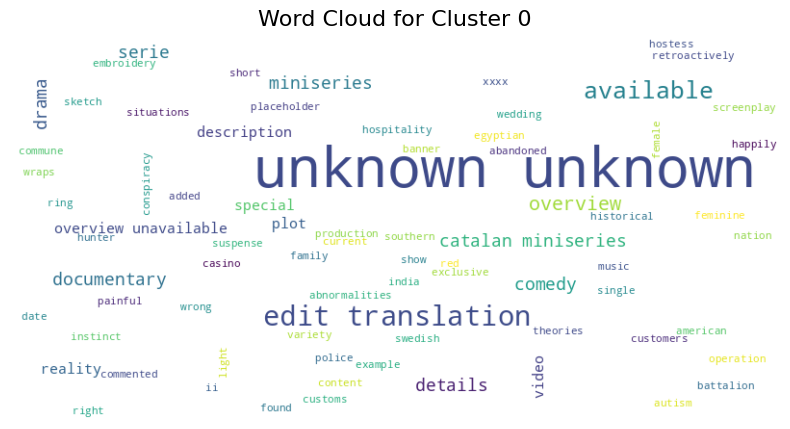

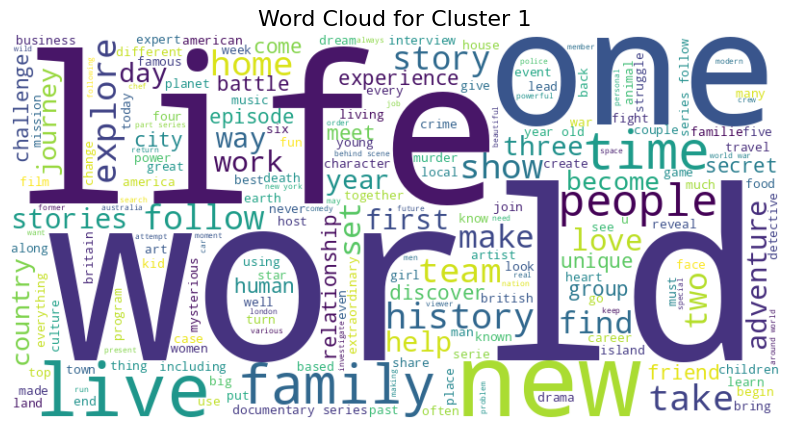

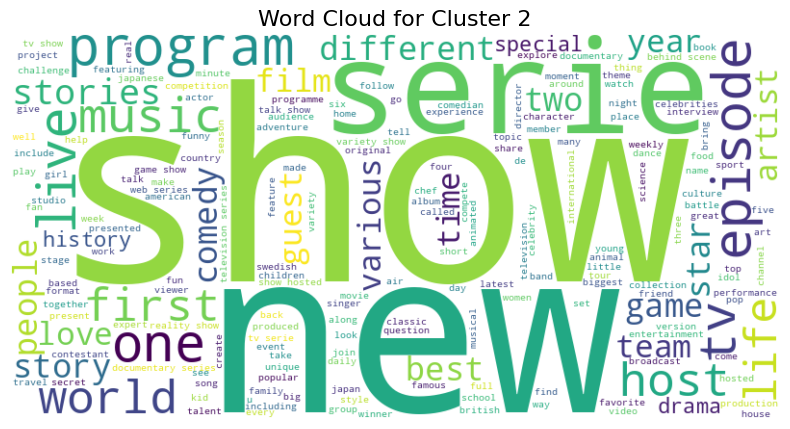

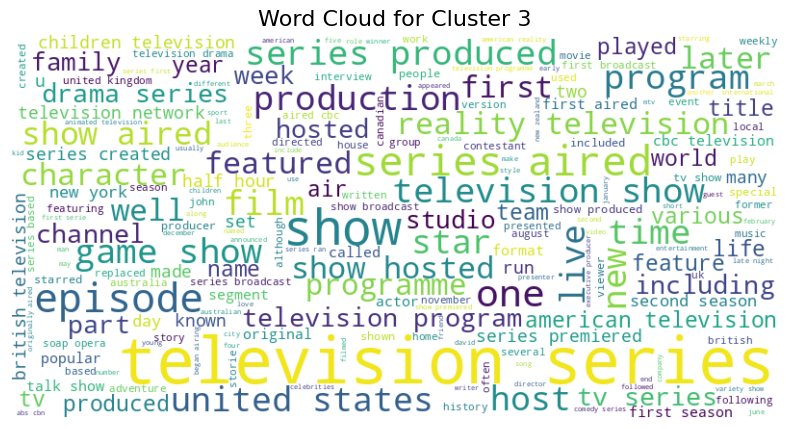

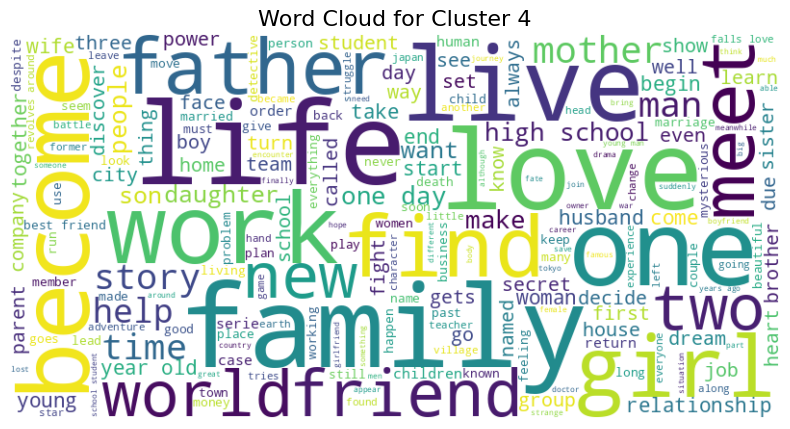

In [14]:
from wordcloud import WordCloud

def generate_word_cloud(cluster_id):
  overviews = df[df['cluster'] == cluster_id]['overview'].fillna('')
  all_words = ' '.join(overviews).lower()
  words = re.findall(r'\b\w+\b', all_words)
  filtered_words = [word for word in words if word not in stop_words]
  text = ' '.join(filtered_words)

  # create the word cloud object
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for Cluster {cluster_id}', fontsize=16)
  plt.show()

# generate word clouds for all clusters
for cluster_id in range(num_clusters):
  generate_word_cloud(cluster_id)


In [15]:
# Good seperation of clusters
# Popularities for each cluster
# Getting a tag (boolean fld ex: including the word 'world')
# If a word is very popular, or two words are corelated ot eachother, find relations between words
# create a feature based on the word (can be multiple words)
# family an dlove can be a feature
# because we are missing 44% of the data, we should combine the overview column with another feature
# if we are able to get a genre for that, we can consider the other 44 percent, so we can populate the missing genre
# Witht he overview column, we can consider how the model performs with the overview column and without it
# If it is not making much of a difference, we can exclude it
# Simple model to predict the existing popularity

# llamma model 

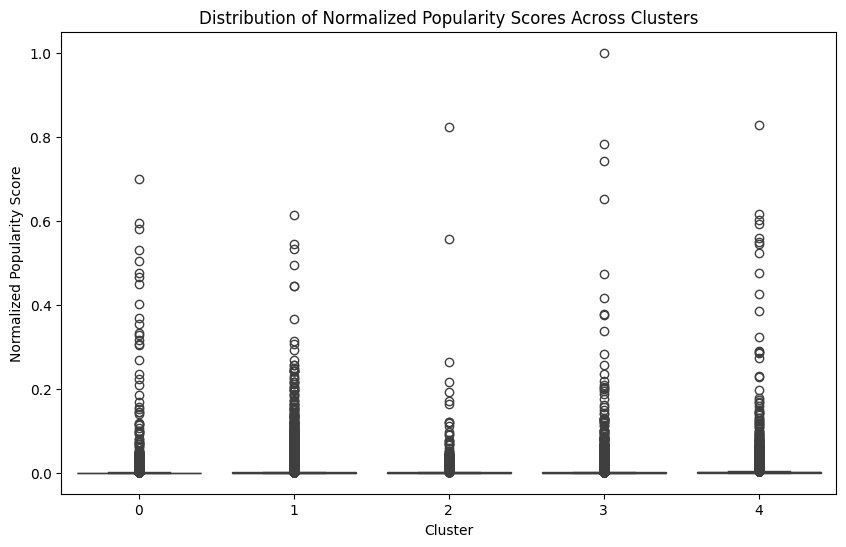

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Choose either MinMaxScaler or StandardScaler based on your needs
scaler = MinMaxScaler()  # Or use StandardScaler for z-score normalization
df['normalized_popularity'] = scaler.fit_transform(df[['popularity']])

# Re-plot with the normalized popularity scores
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='normalized_popularity', data=df)
plt.xlabel('Cluster')
plt.ylabel('Normalized Popularity Score')
plt.title('Distribution of Normalized Popularity Scores Across Clusters')
plt.show()

# do some log transformation
# check how many rows have a missing overview but has a genre and vice versa
# If both are missing we can ignore for now and see how the BERT model performs